### Overview

This tutorial demonstrates how to use Longcell to analyze single cell isoform count data. Due to the frequent truncations in Nanopore long reads sequencing and to allow for identification of new ioforms, Longcell stores the isoform information as sequence of exons. So instead of building a cell-by-isoform matrix, the information of gene expression and isoform expression are stored seperately. 

The general steps for the analysis are:

1. regular scRNA-seq gene expression analysis.

2. identify highly variable exons

3. differetial alternative splicing analysis between cell groups

We add interface to Seurat, thus you can do both general scRNA-seq gene expression analysis and alternative splicing analysis within a Seurat object.

First, we load Longcell and the other packages necessary for this vignette.

In [9]:
library(Longcell)
library(Seurat)
library(dplyr)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union




### annotation

In [2]:
gene_bed = readRDS("../tests/annotation/gene_bed.rds")
gtf = readRDS("../tests/annotation/exon_gtf.rds")

### data

Here we are using the sample of colorecatal metastasis to liver published in our paper as an example. The single cell isoform quantification for this sample has been generated by Longcell-pre.

We can directly generate a Seurat object from the output of Longcell-pre.The Splice object is embedded in the `misc` slot of the Seurat object, which stores the single cell isoform count. You can get access to it via `getSplice(object)`

In [3]:
crc = createSpliceSeurat(path = "../tests/data/",project = "colorectal",min.cells = 3,min.features = 200)

In [4]:
getSplice(crc)

Splice object with  239  cells and  14733 genes

We could check the isoform count for each gene in each cell via `getIsoform(object,gene)`, for example:

In [5]:
crc_MYL6_iso = getIsoform(crc,"MYL6")
head(crc_MYL6_iso)

,cell,gene,start,exons,end,count,polyA
,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
2729,AAACGGGGTTATGTGC,MYL6,56158371,11|12|13|14|17|22|23|24|27|28|29|31|32|39|40|41,56161573,0,1.0000000
2730,AAACGGGGTTATGTGC,MYL6,56158371,11|12|13|14|17|22|23|24|27|28|29|31|32|39|40|41|42,56161577,1,1.0000000
2731,AAACGGGGTTATGTGC,MYL6,56160017,28|29|31|32|39|40|41,56161572,0,1.0000000
2732,AAACGGGGTTATGTGC,MYL6,56160017,28|29|31|32|39|40|41,56161575,1,0.9736842
2733,AAACGGGGTTATGTGC,MYL6,56158359,6|7|8|9|10|11|12|13|14|17|22|23|24|27|28|29|31|32|35|39|40|41,56161574,1,0.9722222
2734,AAACGGGGTTATGTGC,MYL6,56158359,6|7|8|9|10|11|12|13|14|17|22|23|24|27|28|29|31|32|39,56161473,0,1.0000000


We can first do general single cell gene count analysis via regular Seurat process to get the cell cluster information

In [6]:
crc <- PercentageFeatureSet(crc, pattern = "^MT-", col.name = "percent.mt")

In [7]:
crc <- SCTransform(crc, method = "glmGamPoi",vars.to.regress = "percent.mt", verbose = FALSE)

In [10]:
crc <-  crc %>%
    RunPCA(npcs = 50, verbose = FALSE,approx = F) %>%
    RunUMAP(reduction = "pca", dims = 1:30,verbose = FALSE) %>% 
    FindNeighbors(reduction = "pca", dims = 1:30,verbose = FALSE) %>% 
    FindClusters(resolution = 1.5,verbose = FALSE) %>% 
    identity()

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


Here we directly use the cell type annotation we get from marker genes to annotate cell clusters.

In [11]:
cell_type = read.table("../tests/data/cell_type.txt",header = TRUE)
rownames(cell_type) = cell_type$cell
crc$type = cell_type[colnames(crc),"type"]

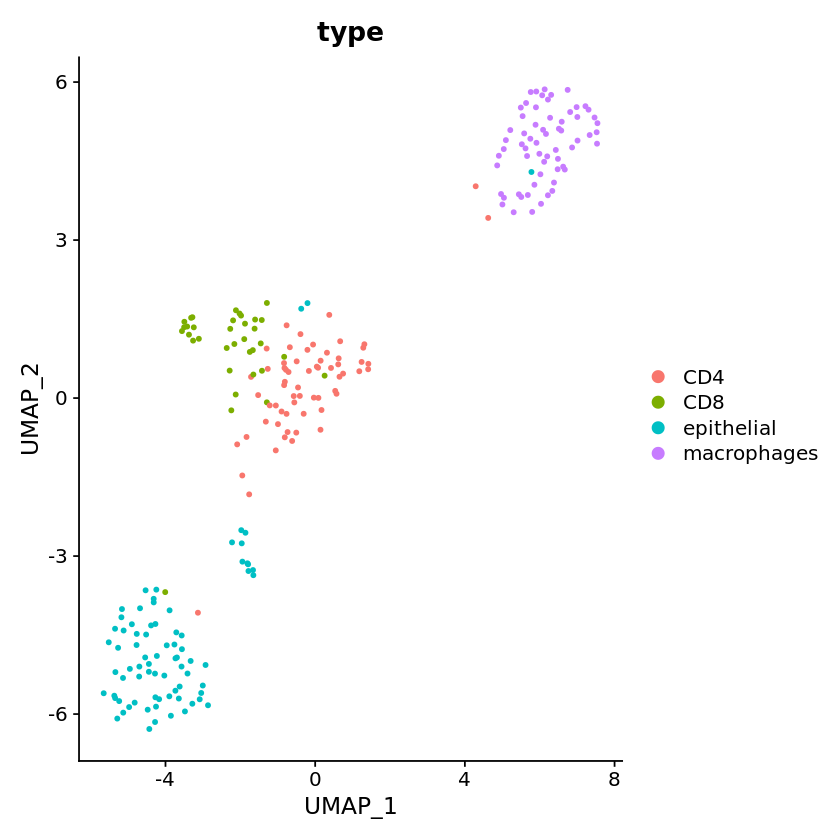

In [12]:
DimPlot(crc, reduction = "umap", group.by = "type",pt.size = 1)

### Single cell heterogeneity of alterative splicing

Alternative splicing heterogeneity can only be confident estimated for genes with high expression in multiple cells, a common threshold is at least 10 transcripts in over 30 cells, thus we could first filter out low expressed genes via their total expression.

In [13]:
heg = HighExprsGene(crc,thresh = 500,slot = "RNA")

In [14]:
head(heg)
length(heg)

[1] "ACTB"    "ACTG1"   "AGR2"    "ALDOA"   "ANAPC11" "ANXA1"

[1] 355

Here 355 genes can be preserved for downstream $\phi$ calculation. The gene bed and exon gtf annotations are optional but recommened. Gene bed annotations can be used to filter out signals from too short exons, which are volunarable to sequencing and mapping errors. Gtf annotation can help merge exons which are always coexisting or mutually exclusive, removing replicative signals. 

In [17]:
crc_phi = genes_exons_phi(crc,genes = heg,gene_bed = gene_bed,gtf = gtf,cores = 8)

The job will be paralleled on  8  cores.


We can then show all valid $\phi$ estimation with small confidence interval in a $\phi$ vs. $\bar{\psi}$ scatter plot

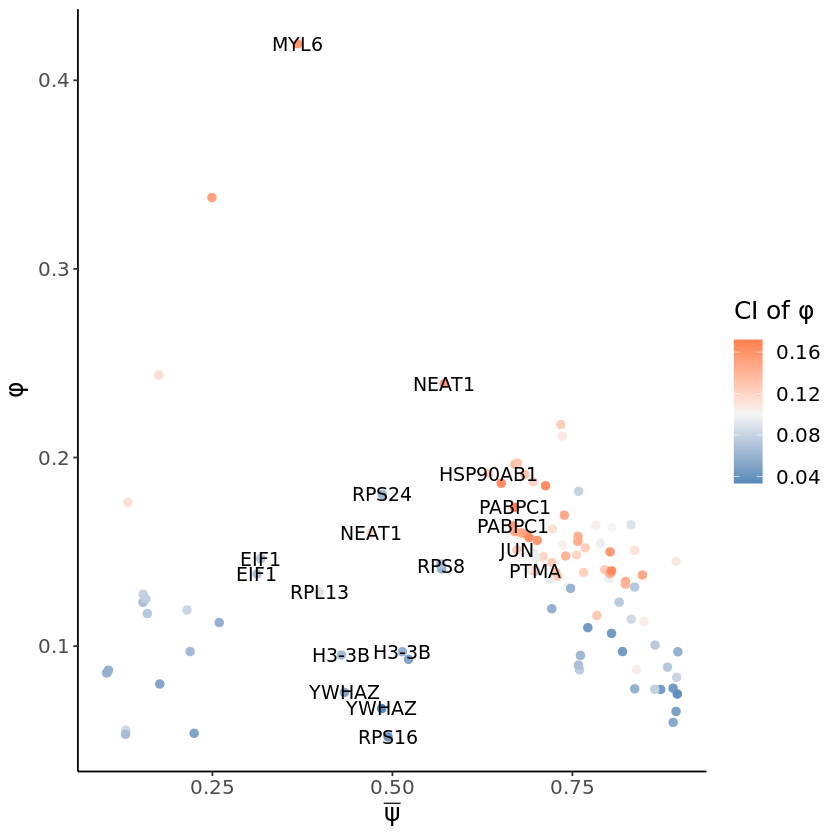

In [18]:
phiPlot(crc_phi,annot_col = "gene",midpoint = 0.1)

We could order the $\phi$ for each exon in a decreasing order, and the top list should be highly variable exons.

In [19]:
head(crc_phi[order(crc_phi$phi,decreasing = TRUE),])

,gene,exon,mean_psi,phi,phi_lwr,phi_upr,count,phi_conf
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
367,MYL6,35,0.3684847,0.4193560,0.3428386,0.5002458,47,0.1574072
1135,SAT1,9,0.2493341,0.3378175,0.2669417,0.4188943,78,0.1519526
1136,SAT1,10,0.1751983,0.2438151,0.1921018,0.3065058,78,0.1144040
399,NEAT1,39,0.5719830,0.2391154,0.1604946,0.3183297,36,0.1578351
1141,SAT1,16,0.7338286,0.2174359,0.1576851,0.2821809,81,0.1244958
1143,SAT1,18,0.7362526,0.2112682,0.1521604,0.2594070,81,0.1072465


Here we use the highest one MYL6 exon35 as an example, we could first show its single cell $\psi$ distribution:

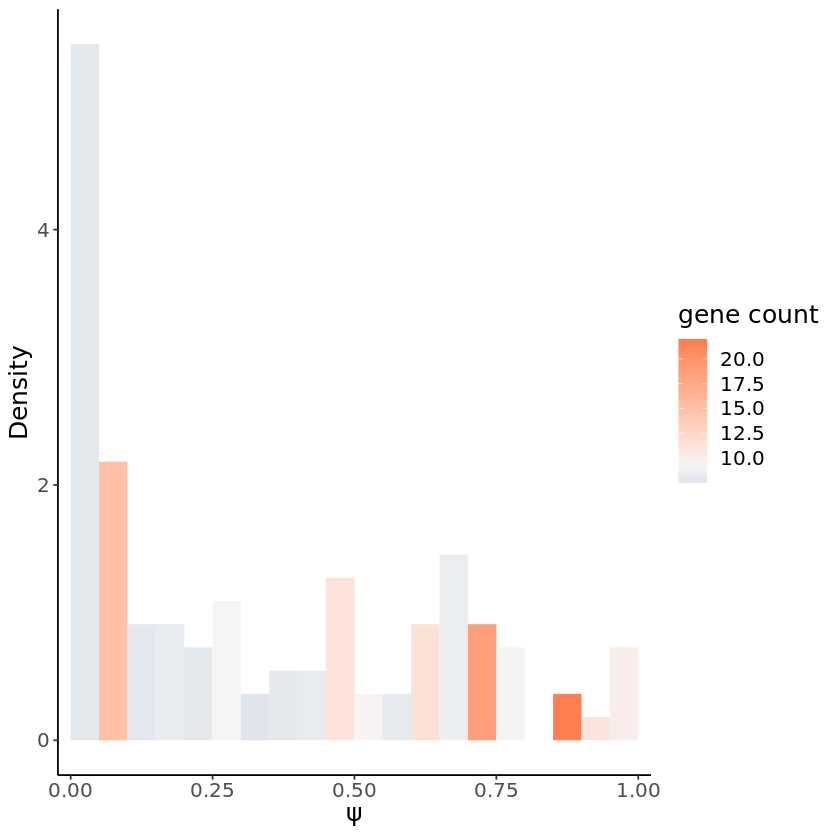

In [20]:
psiHist(crc,gene = "MYL6",exon = "35")

[[1]]


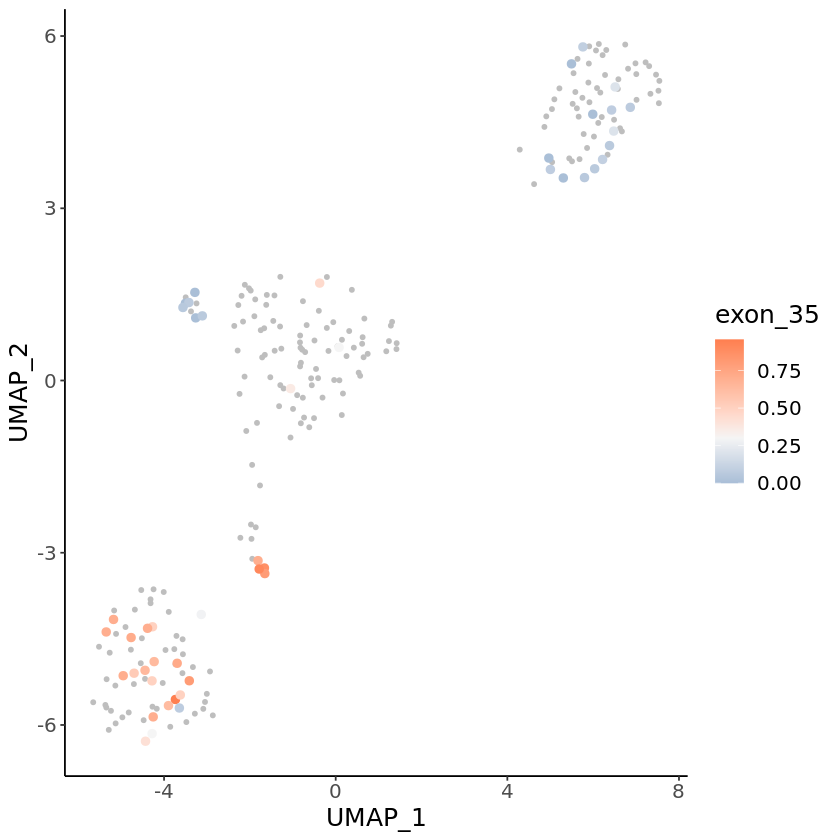

In [21]:
psiCellPlot(crc,gene = "MYL6",exons = "35",cell_embedding = "umap")

We could see very different alternative splicing patterns for this exon in epithlials and other immune cells. Epithlials highly spliced in the exon 35 in MYL6, while T cells and macrophages tend to splice this exon out.

### Generalized Likelihood Ratio Test

Since we have found the splicing heterogeneity between epithelials and immune cells, here we could do a differential alternative splicig analysis between the two cell groups to see if they have other more splicing difference.

We first specify the non-epithelial cells as immune cells in the cell type annotation

In [22]:
crc$group = ifelse(crc$type == "epithelial","epithelial","immune")

Then we could do generalized likelihood ratio test for highly expressed genes for immune cells and epithelials to see if they have alternative splicing difference.

In [33]:
crc_GLRT_sig = genes_groups_GLRT(crc,genes = heg,
                              group1s = "epithelial",group2s = "immune",group_col = "group",
                              gene_bed = gene_bed,gtf = gtf,q_thresh = 0.05,cores = 8)

The job will be paralleled on  8  cores.


Compared to epthelials, most exons show decreasing splice-in in immune cells as most of them show negative mean change.

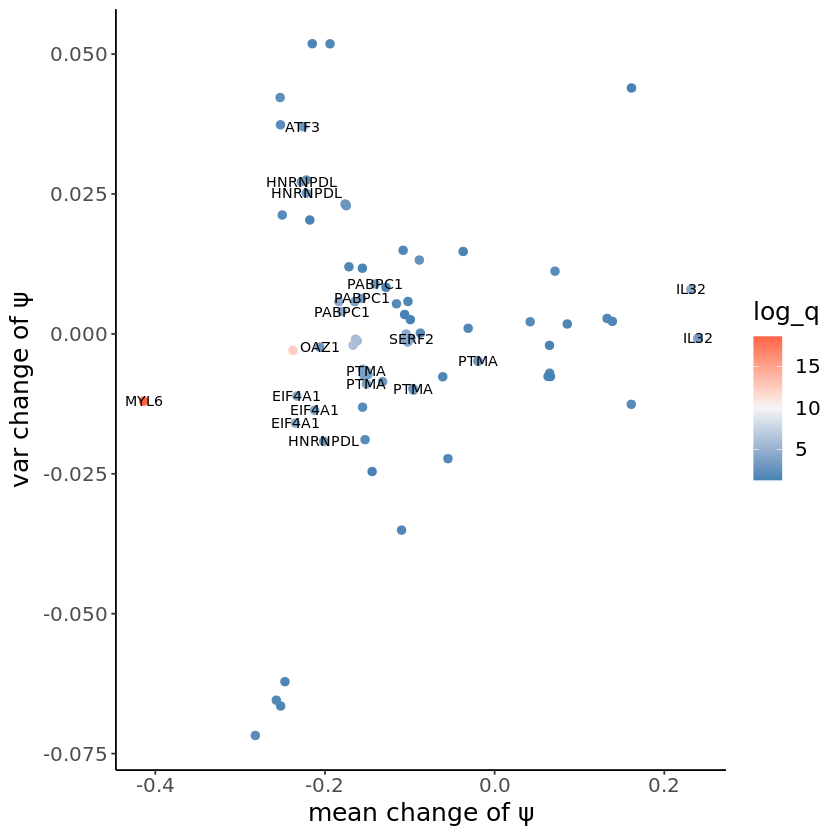

In [84]:
GLRT_sig_plot(crc_GLRT_sig)

In [40]:
head(crc_GLRT_sig[order(crc_GLRT_sig$q),])

,gene,group1,group2,exon,p,alpha1,beta1,alpha2,beta2,q,mean_diff,var_diff
,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
633,MYL6,epithelial,immune,35,2.309757e-22,4.585580,3.364490,1.296922,6.654382,2.556901e-19,-0.4136894,-0.0120241663
913,RPS24,epithelial,immune,31,6.644542e-16,6.683290,3.766842,5.211762,7.757096,3.677754e-13,-0.2376737,-0.0029256764
924,RPS8,epithelial,immune,26,2.079360e-09,8.228405,4.128133,8.025231,8.055760,7.672839e-07,-0.1668643,-0.0020203249
923,RPS8,epithelial,immune,25,5.550707e-09,8.273600,4.109817,7.561798,7.435223,1.536158e-06,-0.1638993,-0.0009411618
922,RPS8,epithelial,immune,20,9.443566e-09,8.125215,4.073930,7.573987,7.448730,2.090806e-06,-0.1618790,-0.0012499424
273,EIF4A1,epithelial,immune,89,2.629369e-07,3.281194,4.891683,1.392122,6.878644,3.325090e-05,-0.2331552,-0.0110961237


We could first check the $\psi$ distribution for MYL6 exon 35 in two cell groups as it's the most significant signal.

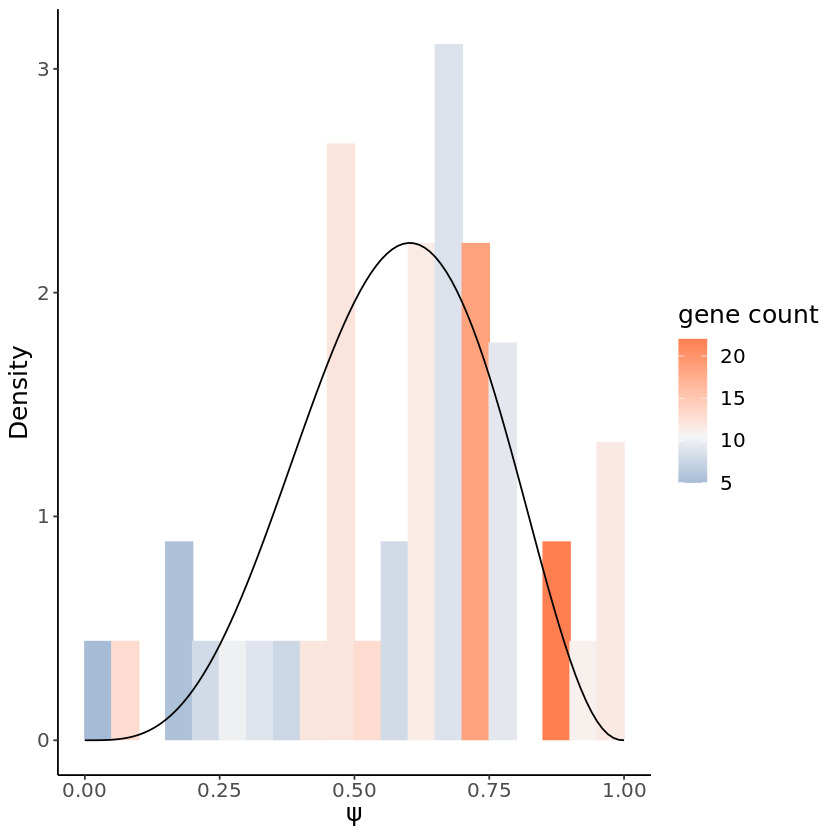

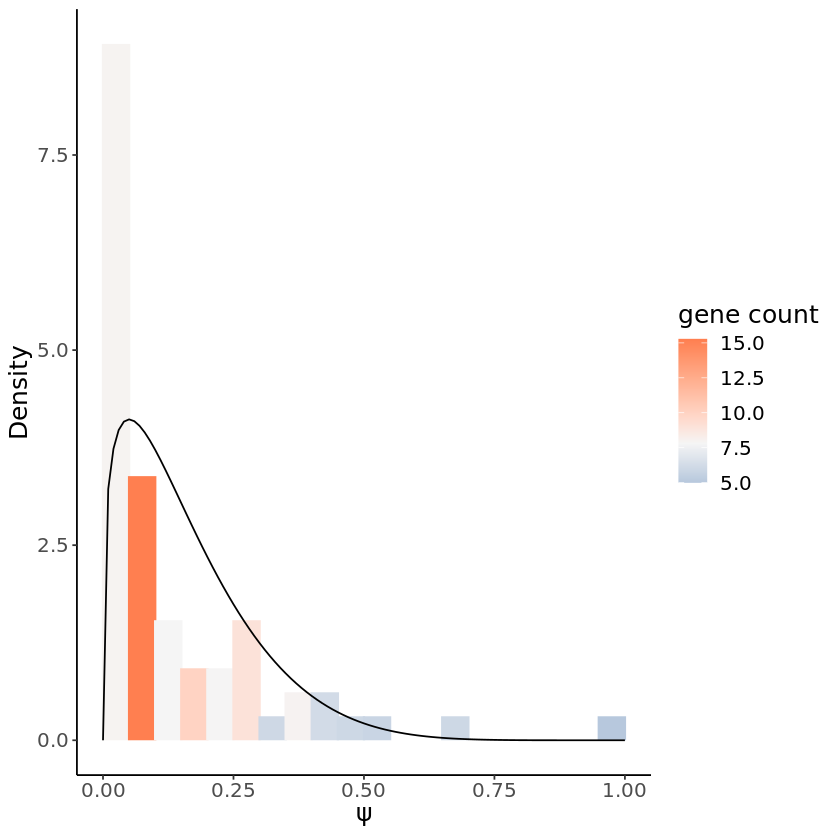

In [88]:
psiHist(crc,gene = "MYL6",exon = "35",group_col = "group",group = "epithelial",
           alpha = 4.585,beta = 3.364)
psiHist(crc,gene = "MYL6",exon = "35",group_col = "group",group = "immune",
            alpha = 1.296922,beta = 6.654382)

We could also check other genes, for example, RPS24:

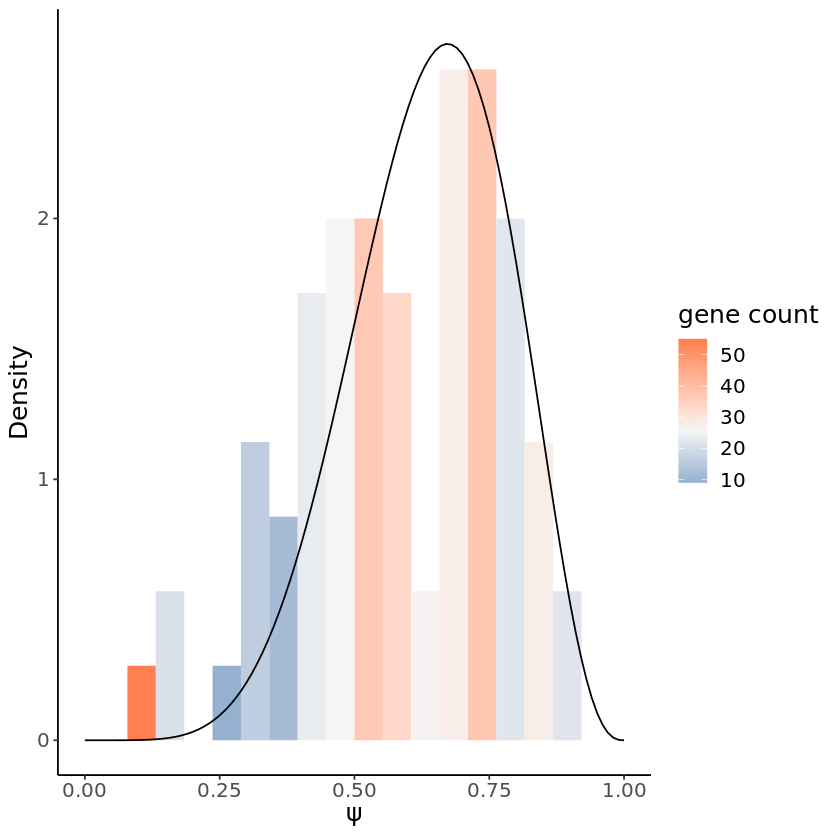

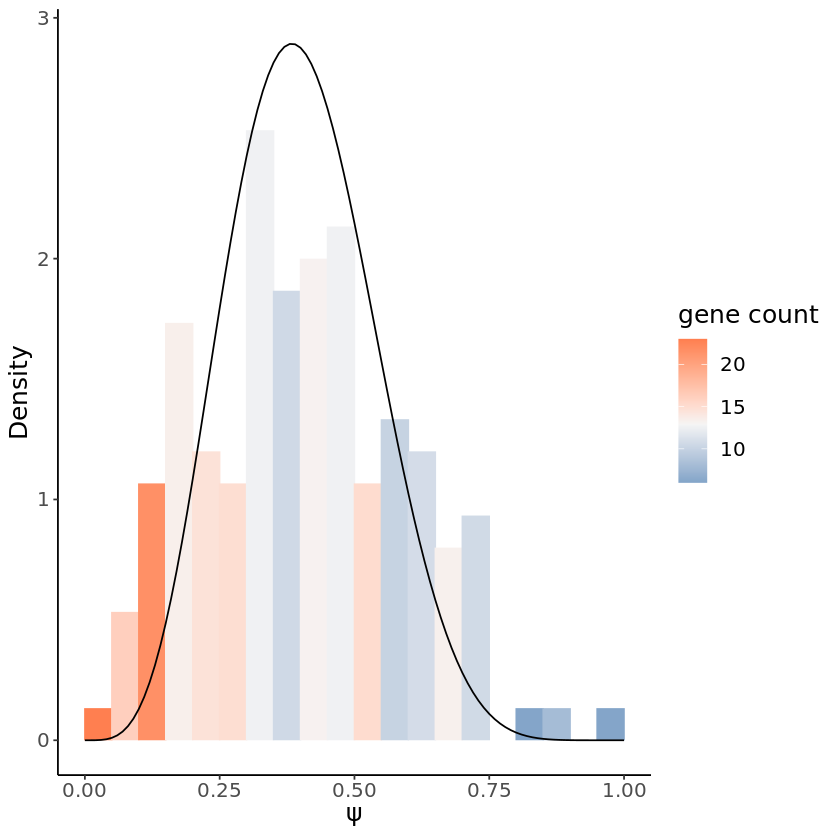

In [89]:
psiHist(crc,gene = "RPS24",exon = "31",group_col = "group",group = "epithelial",
           alpha = 6.683290,beta = 3.766842)
psiHist(crc,gene = "RPS24",exon = "31",group_col = "group",group = "immune",
            alpha = 5.211762,beta = 7.757096)